In [3]:
# JAX-based Slime Mold Foraging Simulation (Stage 1)

import jax
import jax.numpy as jnp
from jax import random, lax
import numpy as np
from noise_custom import Perlin, perlin_multi_octave
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree

from ipyleaflet import Map, Marker, basemaps, GeoJSON, FullScreenControl, DivIcon, Polyline, CircleMarker
import pandas as pd
import json
from PIL import Image
import os

In [ ]:
# Load the grid from output.json
def load_grid_from_json(file_path):
    '''
    Load a grid from a JSON file and convert it to a JAX array.
    Args:
        file_path (str): Path to the JSON file containing the grid data.
    Returns:
        jax.numpy.ndarray: A JAX array representing the grid.
    '''
    with open(file_path, 'r') as f:
        data = json.load(f)
    return jnp.array(data)

map_with_stations = load_grid_from_json('distance-calculations/output.json')
# flip the map to be in x,y coordinates
map_with_stations = jnp.flipud(map_with_stations)
map_with_stations = jnp.array(map_with_stations).T

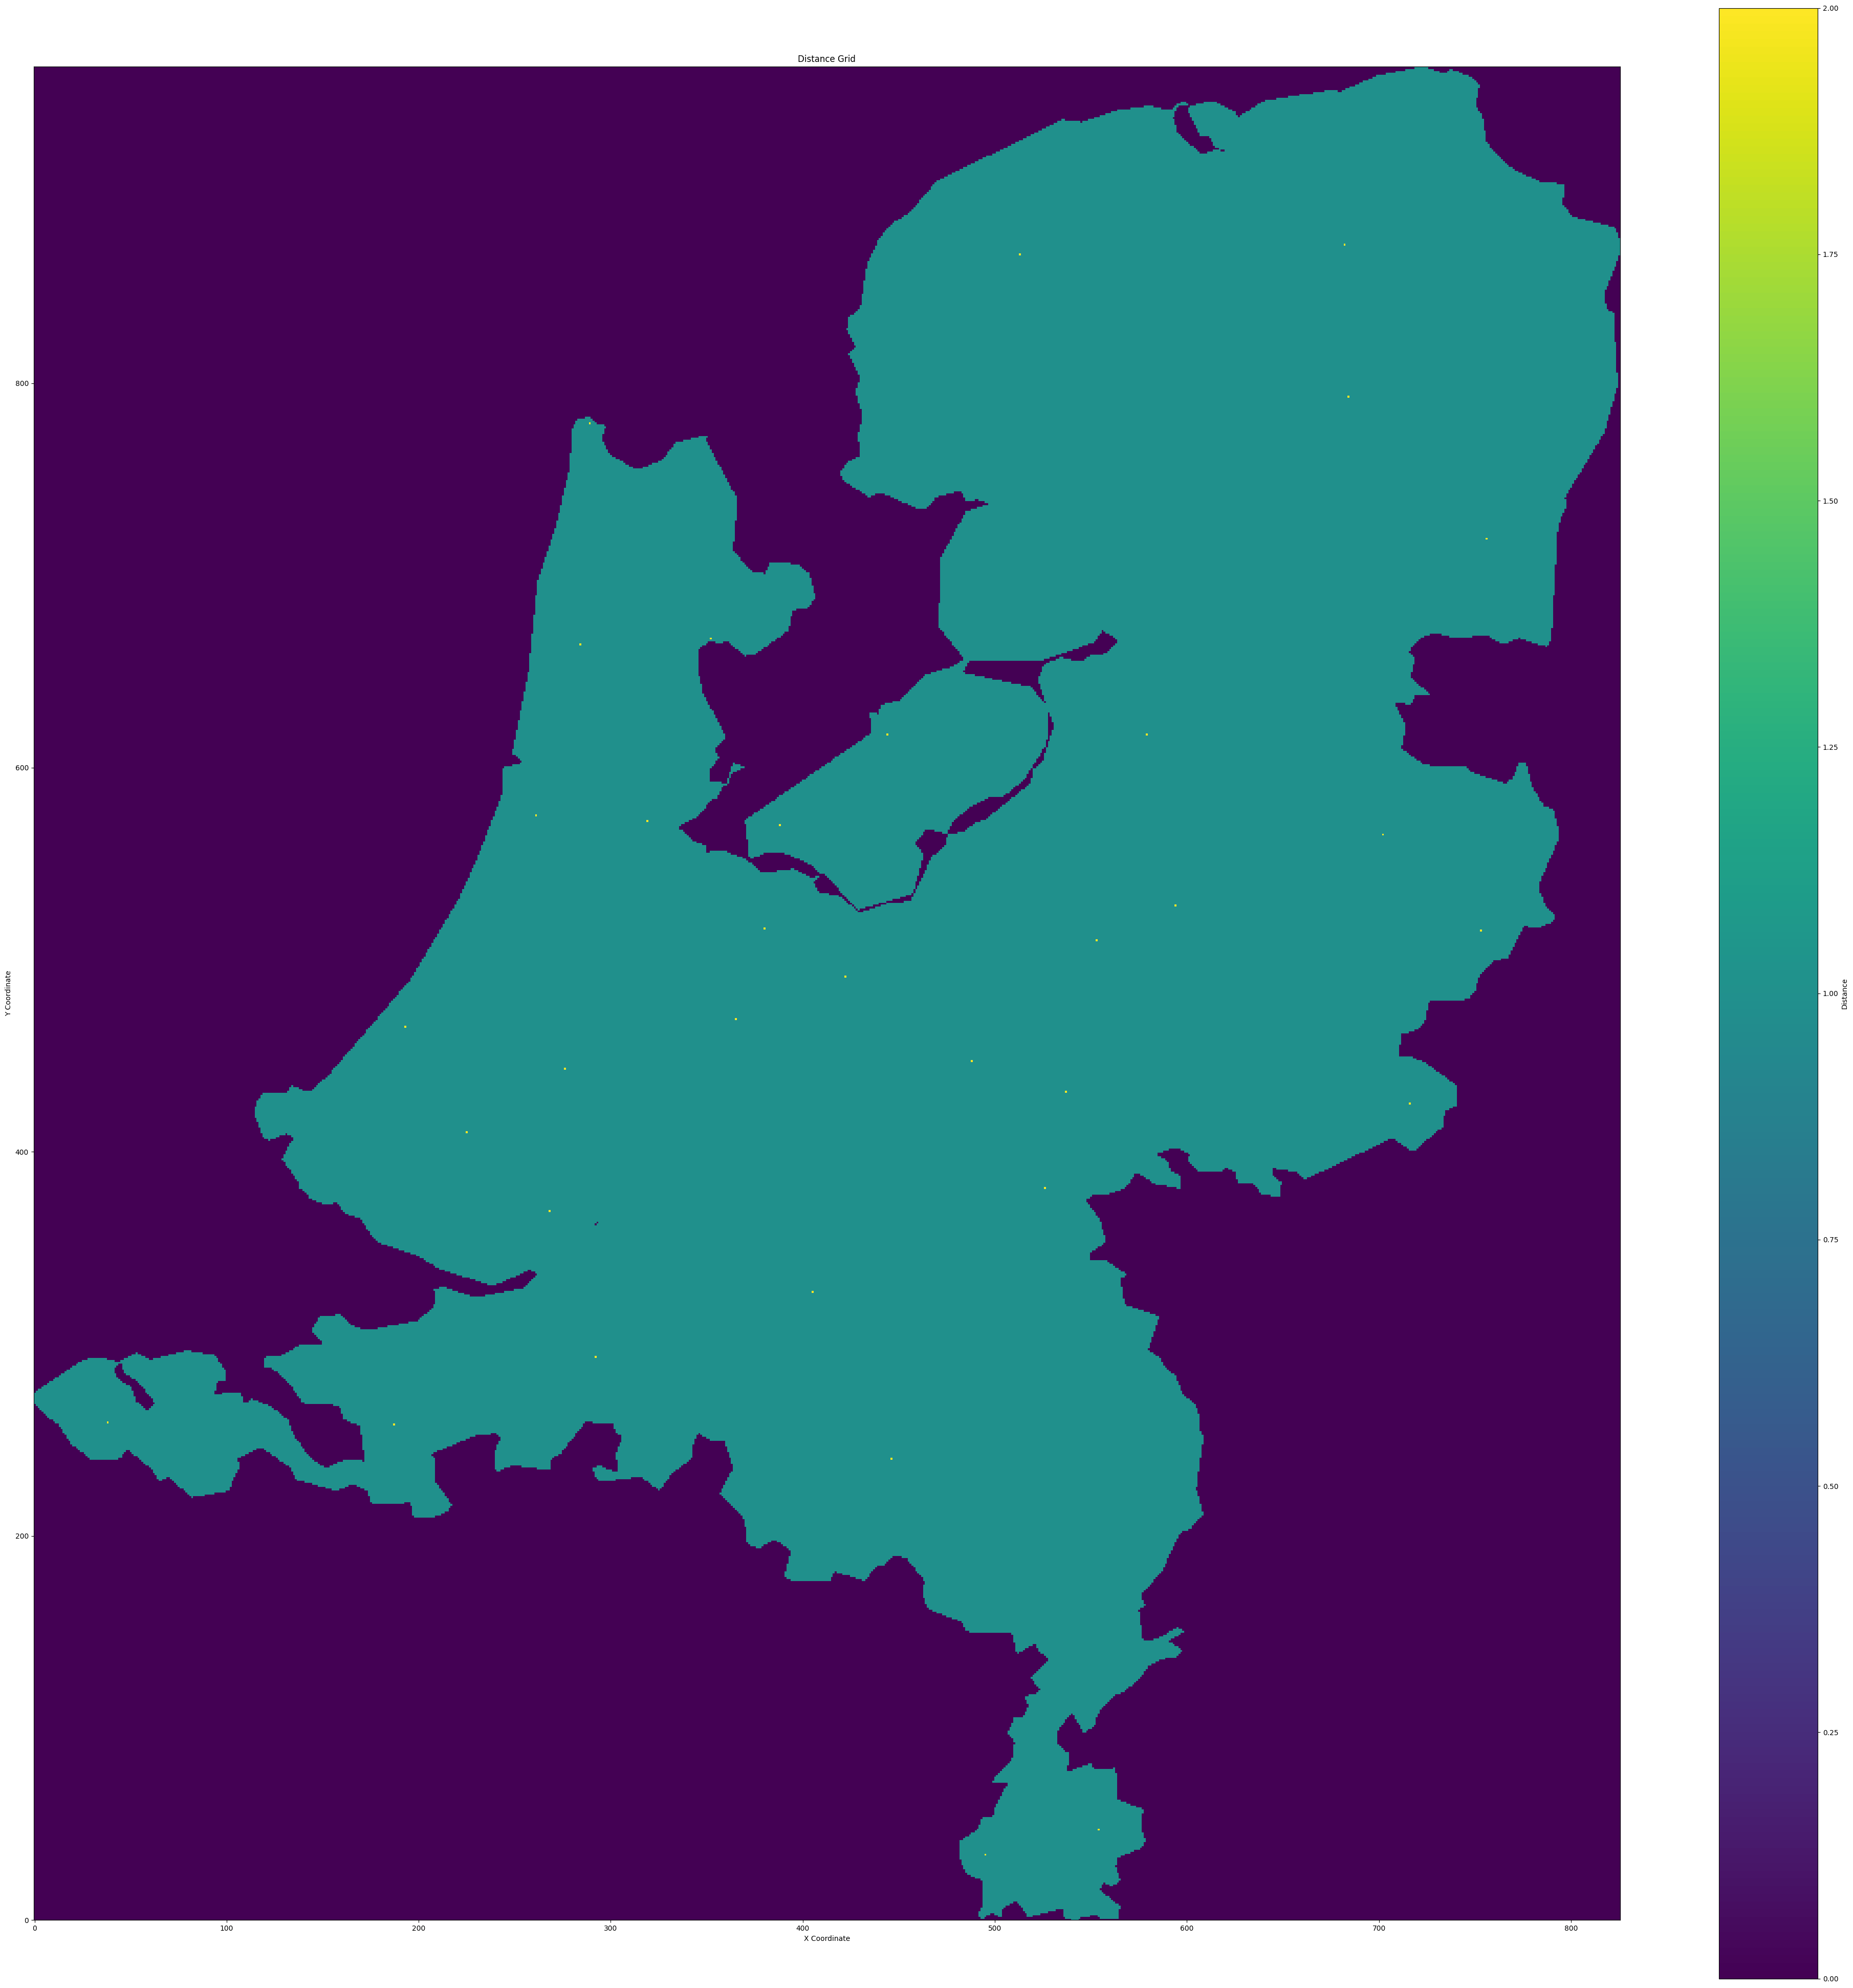

In [7]:
# Plot the grid using Matplotlib
plt.figure(figsize=(50, 50))
plt.imshow(map_with_stations.T, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Distance Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.ylim(0, map_with_stations.shape[1])  # Invert y-axis to match the original grid orientation
plt.show()

In [ ]:
def get_agent_seed(experiment_seed, agent_idx, dim):
    # create a unique seed for each agent, simulation, and dimension (x,y)
    return hash((experiment_seed, agent_idx, dim))

def generate_noise_array(n_frames, total_agents, fps, experiment_seed=0):
    """
    Precompute Perlin noise for all agents and timesteps.
    Args:
        n_frames (int): Number of frames to generate noise for.
        total_agents (int): Total number of agents.
        fps (int): Frames per second, used for time scaling in noise generation.
        experiment_seed (int): Seed for random number generation to ensure reproducibility.
    Returns:
        jax.numpy.ndarray: A 3D array of shape (n_frames, total_agents, 2) containing noise values for each agent and frame.
    """
    n_frames_noise = jnp.round(1.5 * n_frames).astype(jnp.int32)
    noise_array = jnp.zeros((n_frames, total_agents, 2))

    # generate offset for each agent and dimension
    offsets = jax.random.uniform(random.PRNGKey(experiment_seed), (total_agents, 2), minval=0, maxval=0.5)
    offsets = jnp.round(offsets * n_frames).astype(jnp.int32)

    for agent in range(total_agents):
        # Generate noise for each agent, with random_start for decorrelation
        p_x = Perlin(seed=get_agent_seed(experiment_seed, agent, 0))
        noise_x_full = jnp.array([
            perlin_multi_octave(p_x, t / fps + p_x.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0)
            for t in range(n_frames_noise)
        ])
        p_y = Perlin(seed=get_agent_seed(experiment_seed, agent, 1))
        noise_y_full = jnp.array([
            perlin_multi_octave(p_y, t / fps + p_y.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0)
            for t in range(n_frames_noise)
        ])
        # Apply the offset for this agent and dimension
        start_x = int(offsets[agent, 0])
        start_y = int(offsets[agent, 1])
        noise_x = noise_x_full[start_x:start_x + n_frames]
        noise_y = noise_y_full[start_y:start_y + n_frames]

        noise = jnp.stack((noise_x, noise_y), axis=-1)
        noise_array = noise_array.at[:, agent].set(noise)

    # set the range of the noise values to be between -1 and 1
    noise_array = (noise_array - jnp.min(noise_array)) / (jnp.max(noise_array) - jnp.min(noise_array)) * 2 - 1
    return noise_array

In [ ]:
def run_simulation(params, noise_array, position_seed):
    """
    Run a single slime mold simulation and return all_trails.

    params: Dictionary containing all simulation parameters.
    noise_array: Precomputed noise array for stochastic movement.
    position_seed: Seed for random starting positions.
    Returns:
        all_trails: JAX array of shape (n_frames, total_agents, 2) containing agent positions.
        start_pos: Initial position of the agents.
    """
    map_with_stations = params["map_with_stations"]
    stations = params["stations"]
    n_agents = params["n_agents"]
    agent_speed = params["agent_speed"]
    n_frames = params["n_frames"]
    force_c = params["force_c"]
    nuclei_sampling_rate = params["nuclei_sampling_rate"]
    depletion_threshold = params["depletion_threshold"]
    total_agents = params["total_agents"]
    random_start = params["random_start"]

    # --- Outer simulation loop in Python ---
    # set the positions to the middle of the grid
    middle_x = map_with_stations.shape[1]//2
    middle_y = map_with_stations.shape[0]//2
    if random_start:
        # Randomly select the index of a 1 in the map_with_stations
        indices = jnp.argwhere(map_with_stations == 1)
        if len(indices) == 0:
            raise ValueError("No valid starting positions found in the map_with_stations.")
        # pick one random index
        random_index = jax.random.choice(random.PRNGKey(position_seed), indices.shape[0], shape=(), replace=False)
        start_pos = indices[random_index]
        # Start all agents at the random position
        positions = [jnp.ones((n_agents, 2)) * start_pos]
    else:
        # Start all agents at the middle of the grid
        start_pos = jnp.array([middle_x, middle_y])
        positions = [jnp.ones((n_agents, 2)) * start_pos]
    station_status = jnp.ones(len(stations)) # 1 means active, 0 means depleted
    station_count = jnp.zeros(len(stations)) # count of agents at each station
    all_trails = jnp.zeros((n_frames, total_agents, 2))

    for t in range(n_frames):
        # Stack all current agent positions
        pos = jnp.vstack(positions)
        n_current_agents = pos.shape[0]

        # Compute deterministic force from the closest active station source for each agent
        vectors = stations[None, :, :] - pos[:, None, :]  # (n_agents, n_stations, 2)
        dists = jnp.linalg.norm(vectors, axis=-1) + 1e-6      # (n_agents, n_stations)
        # Mask out inactive station sources by setting their distance to a large value
        masked_dists = dists + (1.0 - station_status[None, :]) * 1e9
        closest_idx = jnp.argmin(masked_dists, axis=1) # (n_agents,)

        # Gather the vector and distance to the closest station source for each agent
        closest_vectors = vectors[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents, 2)
        closest_dists = masked_dists[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents,)

        min_dist = 1.0  # Prevent division by very small distances
        safe_dists = jnp.maximum(closest_dists, min_dist)
        force_mag = jnp.sqrt(force_c / safe_dists)
        force_dir = closest_vectors / safe_dists[..., None]
        deterministic = force_dir * force_mag[..., None]  # (n_agents, 2)
        
        # Stochastic force
        stochastic = noise_array[t, :n_current_agents]
        move_vec = deterministic + stochastic
        move_vec /= jnp.linalg.norm(move_vec, axis=1, keepdims=True) + 1e-6  # Normalize to unit length
        # Scale by agent speed
        move_vec = move_vec * agent_speed 
        # Check if the new position is allowed (map_with_stations !=0) 
        new_pos = pos + move_vec
        allowed = map_with_stations[
            new_pos[:, 0].astype(jnp.int32), 
            new_pos[:, 1].astype(jnp.int32)
        ] != 0
        new_pos = jnp.where(allowed[:, None], new_pos, pos)

        # Check for agents
        reached = jnp.linalg.norm(new_pos[:, None, :] - stations[None, :, :], axis=-1) < 5.0
        station_counts = jnp.sum(reached, axis=0)
        # Find which station sources are newly depleted this step
        newly_depleted = (station_status == 1) & (station_counts >= depletion_threshold)
        station_status = station_status * (station_counts < depletion_threshold)

        # For each newly depleted station source, spawn n_agents at its location
        for i, depleted in enumerate(newly_depleted):
            if depleted:
                print(f"station source {i} depleted at timestep {t//60}.")
                spawn = jnp.tile(stations[i], (n_agents, 1)).astype(jnp.float32)
                positions.append(spawn)

        # Save trail for plotting
        all_trails = all_trails.at[t, :n_current_agents].set(pos[:n_current_agents])

        # Update positions for next step
        positions[:n_current_agents] = new_pos

        # Stop if all station sources are depleted
        if jnp.all(station_status == 0):
            print(f"All station sources depleted. Stop at timestep {t//60}.")
            # get rid of the positions that are zero,zero in all_trails
            all_trails = all_trails[:t]
            all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
            break
        elif t == n_frames - 1:
            print(f"Reached max timesteps. Stop at timestep {t//60}.")
            # get rid of the positions that are zero,zero in all_trails
            all_trails = all_trails[:t]
            all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
            break

    return np.array(all_trails), start_pos  # Convert to numpy for saving

def run_multiple_experiments(params, seeds, output_folder, generate_noise_array_func):
    """
    Run multiple experiments with different seeds and save the results.
    params: Dictionary containing all simulation parameters.
    seeds: List of random seeds for each experiment.
    output_folder: Folder to save the results.
    generate_noise_array_func: Function to generate the noise array.
    """
    os.makedirs(output_folder, exist_ok=True)
    for i, seed in enumerate(seeds):
        print(f"Running experiment {i+1}/{len(seeds)} with seed {seed}")
        # Update params with current seed-dependent values
        stations = jnp.where(params["map_with_stations"] == 2)
        stations = jnp.array(stations).T
        total_agents = len(stations) * params["n_agents"]
        params["stations"] = stations
        params["total_agents"] = total_agents

        noise_array = generate_noise_array_func(
            params["n_frames"], total_agents, fps=params["fps"], experiment_seed=seed
        )
        all_trails, start_pos = run_simulation(params, noise_array, seed)
        np.savez(
            os.path.join(output_folder, f"experiment_{i+1:02d}_seed_{seed}.npz"),
            all_trails=all_trails,
            seed=seed,
            nuclei = all_trails[::params["nuclei_sampling_rate"]],  # Save nuclei positions
            stations=params["stations"],
            map_with_stations=params["map_with_stations"],
            start_pos = start_pos
        )
        print(f"Saved results for experiment {i+1}.")

In [ ]:
# Set the paramters for the simulation
params = {
    "map_with_stations": map_with_stations,
    "n_agents": 20,
    "agent_speed": 1.5,
    "n_frames": 60 * 60,
    "force_c": 10.0,
    "nuclei_sampling_rate": 20,
    "depletion_threshold": 4,
    "fps": 60,
    "random_start": False #Same starting positions for all experiments
}
seeds = np.linspace(1, 30, 30, dtype=int).tolist()  # Generate seeds from 1 to 30 for the different experiments

# Run the experiments with the same starting positions
run_multiple_experiments(
    params=params,
    seeds=seeds,
    output_folder="experiment_outputs_same_starts",
    generate_noise_array_func=generate_noise_array
)

Running experiment 1/30 with seed 1
station source 19 depleted at timestep 0.
station source 23 depleted at timestep 0.
station source 22 depleted at timestep 1.
station source 24 depleted at timestep 2.
station source 16 depleted at timestep 2.
station source 27 depleted at timestep 2.
station source 15 depleted at timestep 3.
station source 13 depleted at timestep 3.
station source 12 depleted at timestep 3.
station source 26 depleted at timestep 3.
station source 18 depleted at timestep 4.
station source 6 depleted at timestep 4.
station source 30 depleted at timestep 5.
station source 3 depleted at timestep 5.
station source 5 depleted at timestep 5.
station source 10 depleted at timestep 5.
station source 9 depleted at timestep 5.
station source 17 depleted at timestep 5.
station source 2 depleted at timestep 5.
station source 32 depleted at timestep 6.
station source 4 depleted at timestep 6.
station source 14 depleted at timestep 6.
station source 1 depleted at timestep 6.
stati

In [ ]:
# Set the parameters
params = {
    "map_with_stations": map_with_stations,
    "n_agents": 20,
    "agent_speed": 1.5,
    "n_frames": 60 * 60,
    "force_c": 10.0,
    "nuclei_sampling_rate": 20,
    "depletion_threshold": 4,
    "fps": 60,
    "random_start": True #Different starting positions for each experiment
}
seeds = np.linspace(1, 30, 30, dtype=int).tolist()  # Generate seeds from 1 to 30 for different starts

# Run the experiments with different starting positions
run_multiple_experiments(
    params=params,
    seeds=seeds,
    output_folder="experiment_outputs_different_starts",
    generate_noise_array_func=generate_noise_array
)

Running experiment 1/30 with seed 1
station source 25 depleted at timestep 4.
station source 20 depleted at timestep 4.
station source 18 depleted at timestep 7.
station source 15 depleted at timestep 8.
station source 9 depleted at timestep 10.
station source 22 depleted at timestep 10.
station source 5 depleted at timestep 10.
station source 23 depleted at timestep 10.
station source 19 depleted at timestep 11.
station source 3 depleted at timestep 11.
station source 6 depleted at timestep 11.
station source 16 depleted at timestep 12.
station source 24 depleted at timestep 12.
station source 2 depleted at timestep 12.
station source 1 depleted at timestep 12.
station source 13 depleted at timestep 12.
station source 27 depleted at timestep 12.
station source 12 depleted at timestep 12.
station source 26 depleted at timestep 13.
station source 4 depleted at timestep 13.
station source 10 depleted at timestep 14.
station source 30 depleted at timestep 14.
station source 7 depleted at 